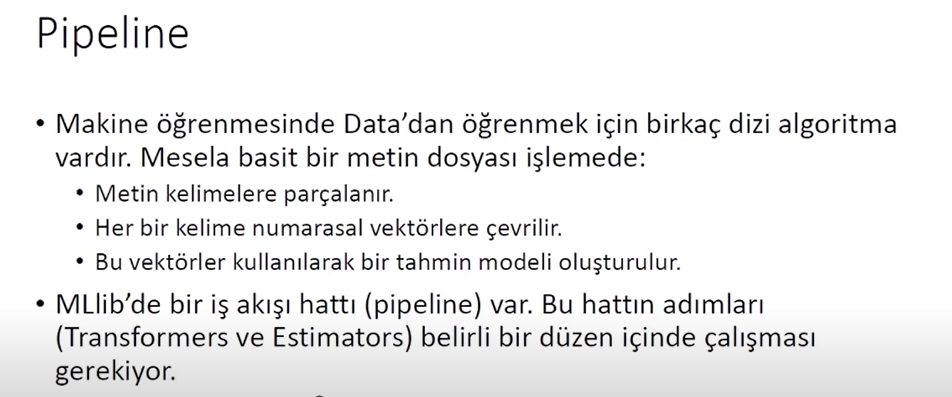

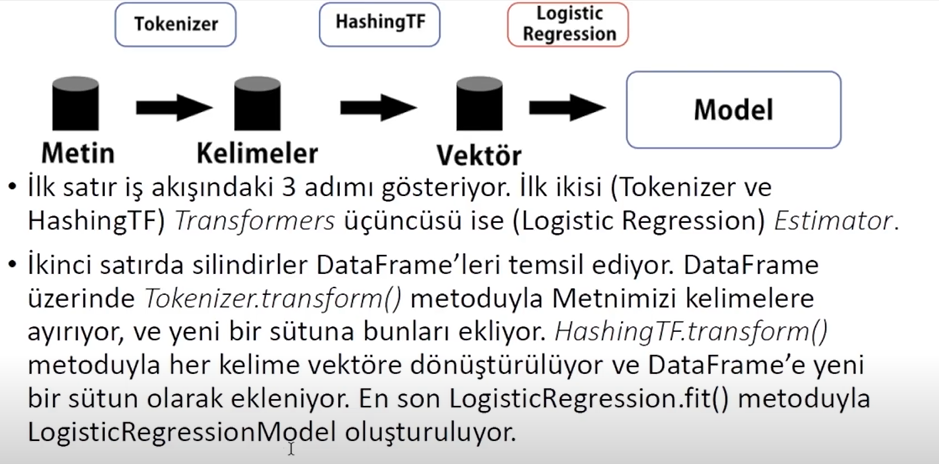

In [3]:
import findspark
findspark.init("C:\\spark")

In [4]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.sql import SparkSession

In [6]:
spark = SparkSession.builder.appName("first_example").getOrCreate()
spark

In [10]:
training = spark.createDataFrame([
    (0, "s p a r k", 1.0),
    (1, "h a d o o p", 0.0),
    (2, "s p a", 1.0),
    (3, "h a d", 0.0),
    (4, "h p a", 0.0)
], ["id", "text", "label"])

training.show()

+---+-----------+-----+
| id|       text|label|
+---+-----------+-----+
|  0|  s p a r k|  1.0|
|  1|h a d o o p|  0.0|
|  2|      s p a|  1.0|
|  3|      h a d|  0.0|
|  4|      h p a|  0.0|
+---+-----------+-----+



In [11]:
tokenizer = Tokenizer(inputCol= "text", outputCol = "words")
hashingTF = HashingTF(inputCol = tokenizer.getOutputCol(), outputCol = "features")
lr = LogisticRegression(maxIter = 10, regParam = 0.01)
pipeline = Pipeline(stages = [tokenizer, hashingTF, lr])

# maxIter: max number of iterations (>= 0). (default: 100, current: 10)
# regParam: regularization parameter (>= 0). (default: 0.0, current: 0.01)

In [12]:
print("LogisticRegression parameters: \n" + lr.explainParams() + "\n")

LogisticRegression parameters: 
aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The bo

In [13]:
model = pipeline.fit(training)

In [14]:
test = spark.createDataFrame([
    (5, "s r k"),
    (6, "h d p"),
    (7, "s p"),
    (8, "h o"),
    (9, "h d p"),
    (10, "p a")
],  ["id", "text"])

In [15]:
prediction = model.transform(test)
prediction.show()

+---+-----+---------+--------------------+--------------------+--------------------+----------+
| id| text|    words|            features|       rawPrediction|         probability|prediction|
+---+-----+---------+--------------------+--------------------+--------------------+----------+
|  5|s r k|[s, r, k]|(262144,[68693,21...|[-4.1608207512036...|[0.01535529127490...|       1.0|
|  6|h d p|[h, d, p]|(262144,[89530,14...|[4.25643402140950...|[0.98602530771388...|       0.0|
|  7|  s p|   [s, p]|(262144,[146929,2...|[-3.1757954008034...|[0.04008681384656...|       1.0|
|  8|  h o|   [h, o]|(262144,[83580,20...|[4.25344479429933...|[0.98598405805862...|       0.0|
|  9|h d p|[h, d, p]|(262144,[89530,14...|[4.25643402140950...|[0.98602530771388...|       0.0|
| 10|  p a|   [p, a]|(262144,[107107,1...|[0.02378038883240...|[0.50594481705782...|       0.0|
+---+-----+---------+--------------------+--------------------+--------------------+----------+



In [17]:
prediction.toPandas()

,id,text,words,features,rawPrediction,probability,prediction
0,5,s r k,"[s, r, k]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-4.160820751203699, 4.160820751203699]","[0.015355291274907312, 0.9846447087250926]",1.0
1,6,h d p,"[h, d, p]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.256434021409508, -4.256434021409508]","[0.9860253077138814, 0.013974692286118575]",0.0
2,7,s p,"[s, p]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-3.1757954008034375, 3.1757954008034375]","[0.04008681384656933, 0.9599131861534307]",1.0
3,8,h o,"[h, o]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.253444794299333, -4.253444794299333]","[0.9859840580586227, 0.014015941941377362]",0.0
4,9,h d p,"[h, d, p]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.256434021409508, -4.256434021409508]","[0.9860253077138814, 0.013974692286118575]",0.0
5,10,p a,"[p, a]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.02378038883240774, -0.02378038883240774]","[0.5059448170578237, 0.4940551829421763]",0.0


In [18]:
selected = prediction.select("id", "text", "prediction")
for row in selected.collect(): print(row)

Row(id=5, text='s r k', prediction=1.0)
Row(id=6, text='h d p', prediction=0.0)
Row(id=7, text='s p', prediction=1.0)
Row(id=8, text='h o', prediction=0.0)
Row(id=9, text='h d p', prediction=0.0)
Row(id=10, text='p a', prediction=0.0)
